### Moving MNIST with What vs Where AutoEncoders

This notebook will implement the autoencoders discussed in the paper "Disentangling Motion from Identity with Barlow Twins Autoencoders".

Author: Geoffrey Mantel

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np
import os
import wandb
from datetime import datetime

from collections import OrderedDict

# Local imports
from models import BarlowTwinsAutoencoder
from datasets import MovingMNIST, MovingMNISTPairs
from utils import animate_mnist, plot_mnist

In [2]:
# Animation imports
%matplotlib inline

In [3]:
config = {
    'batch_size': 200,
    'num_epochs': 100,
    'what_latent_dim': 512,
    'where_latent_dim': 32,
    'learning_rate': 1e-3,
    'off_diagonal_ratio': 0.05,
    'barlow_lambda': 10.0,
    'optimizer': 'Adam',
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}


#### Training Section

This section iterates across different levels of loss mixing. Higher Barlow Twins terms should encourage
greater separation between "what" and "where", at the cost of increased difficulty of reconstructing the input

In [ ]:
# Load the training and testing data sets
training_set    = MovingMNISTPairs(root='./data/MovingMNIST', train=True, device=config['device'])
training_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=config['batch_size'])

# Shuffling the testing set is important to correctly compute the BT loss in validation
testing_set    = MovingMNISTPairs(root='./data/MovingMNIST', train=False, device=config['device'])
testing_loader = torch.utils.data.DataLoader(testing_set, shuffle=True, batch_size=config['batch_size'])

In [ ]:
#
# Experiment with different values of off-diagonal ratios
#
for barlow_lambda in [0.1, 0.01]:
    config['barlow_lambda'] = barlow_lambda
    model = BarlowTwinsAutoencoder(config=config)
    
    # Log experiment to wandb.ai
    run = wandb.init(project='BT_Autoencoder', entity='gmantel', config=config)
    wandb.run.name = 'run_{}'.format(datetime.now())
    wandb.watch(model)
    
    for epoch in range(config['num_epochs']):
        audit_log = model.fit(training_loader, testing_loader, config=config)
        wandb.log(audit_log)
    
    # Save the model and finish the run
    model.save('./saves/bt_autoencoder3_{}.pt'.format(barlow_lambda))
    run.finish()

#### Analysis Section

In this section, we will examine the results of training, comparing different lambda mixing ratios to see the impact on video frame reconstruction

In [4]:
# Grab a batch of videos from the experiment dataset
experiment_set = MovingMNIST(root='./data/MovingMNIST', train=False, device=config['device'])
experiment_loader = torch.utils.data.DataLoader(experiment_set, shuffle=False, batch_size=200)
batch_idx, data = next(enumerate(experiment_loader))

In [72]:
model = BarlowTwinsAutoencoder(config=config)
model.load('./saves/bt_autoencoder3_10.pt')

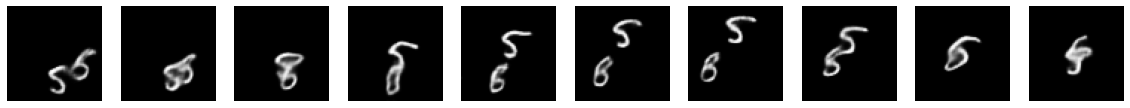

In [73]:
# Just select a single video of 20 frames, encode it, decode it, and animate it
# This video should be a '5' and an '8'
with torch.no_grad():
    model.eval()
    z_what1 = model.what_encoder(torch.unsqueeze(data[0], 1))
    z_where1 = model.where_encoder(torch.unsqueeze(data[0], 1))
    z = torch.cat((z_what1, z_where1), dim=1)
    x = model.decoder(z)
    
#animate_mnist(x.reshape(20, 64, 64),framerate=10)
plot_mnist(x)

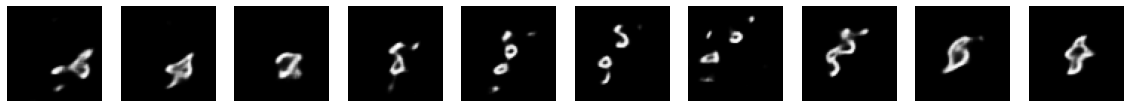

In [74]:
# To see what each set of encoders is learning (and what the decoder is learning from their output)
# we will zero out one of the decoders while generating the output from another decoder:

zwhat_zero = torch.zeros_like(z_what1)
zwhere_zero = torch.zeros_like(z_where1)

# First look at the reconstruction with only the "where" encoder:
with torch.no_grad():
    model.eval()
    z = torch.cat((zwhat_zero, z_where1), dim=1)
    x = model.decoder(z)
    
#animate_mnist(x.reshape(20, 64, 64),framerate=10)
plot_mnist(x)

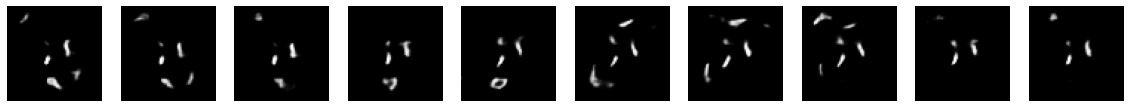

In [75]:
# Then look at the reconstruction with only the "what" encoder:
with torch.no_grad():
    model.eval()
    z = torch.cat((z_what1, zwhere_zero), dim=1)
    x = model.decoder(z)
    
#animate_mnist(x.reshape(20, 64, 64),framerate=10)
plot_mnist(x)

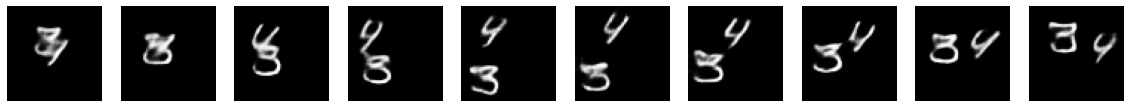

In [76]:
# Do the same for the next video - this should be a '3' and a '4'
with torch.no_grad():
    model.eval()
    z_what2 = model.what_encoder(torch.unsqueeze(data[3], 1))
    z_where2 = model.where_encoder(torch.unsqueeze(data[3], 1))
    z = torch.cat((z_what2, z_where2), dim=1)
    x = model.decoder(z)
    
#animate_mnist(x.reshape(20, 64, 64),framerate=10)
plot_mnist(x)

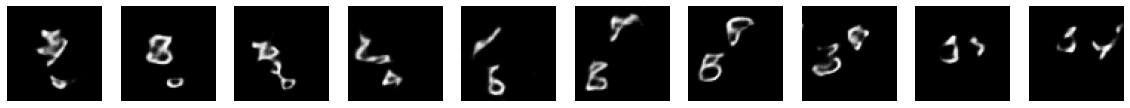

In [77]:
# Finally, we will examine the mixing between the two encoders.
# If the "what" encoder is genuinely learning the invariant contents of the video, and the "where" encoder
# is learning the movement, swapping them should swap the contents and movement of the two digits

# This first video will be the "what" encoding for a '5' and an '8' with the "where" encoding of the '4' and the '3' video
with torch.no_grad():
    model.eval()
    z = torch.cat((z_what1, z_where2), dim=1)
    x = model.decoder(z)
    
#animate_mnist(x.reshape(20, 64, 64),framerate=10)
plot_mnist(x)

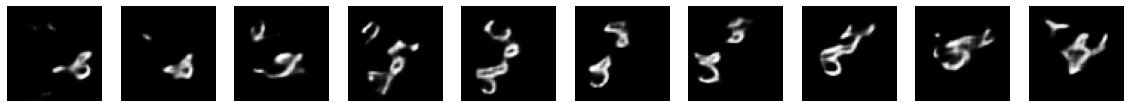

In [78]:
# This second video will be the "what" encoding for a '4' and a '3' with the "where" encoding of the '5' and the '8'
with torch.no_grad():
    model.eval()
    z = torch.cat((z_what2, z_where1), dim=1)
    x = model.decoder(z)
    
#animate_mnist(x.reshape(20, 64, 64),framerate=10)
plot_mnist(x)